In [1]:
%reset -f

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [3]:
import os
import sys
sys.path.append('../')

In [4]:
from model import UnicycleModel
from cost import UnicycleCost
from constraints import UnicycleConstraints
from scipy.integrate import solve_ivp
from matplotlib.patches import Ellipse
from utils.utils_alg import get_neighbor_vec,get_K_discrete
from utils.utils_plot import plot_traj,plot_traj_set,plot_state_input,plot_comparison

from trajopt import trajopt
from funlopt import funlopt
from Lipschitz import Lipschitz
from Scaling import TrajectoryScaling

from utils.utils_alg import get_sample_eta_w,propagate_model
import cvxpy as cvx
from scipy.integrate import solve_ivp



(CVXPY) Nov 15 12:01:13 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <F9700F1C-290B-3DF3-8D09-CFDF44BAE051> /opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so\n  Reason: tried: '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")


In [5]:
N = 30
tf = 10
delT = tf/N

## obstacle setting

In [6]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []


c_list.append([1.8,0.3])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([2*2/3,3.5])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([4.2,0.7])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([3.8,3.5])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([10*2/3,0.5])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([6.5,4])
H_list.append(get_H_obs(0.5,0.5))



c_list.append([4*2/3,1.7])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([8*2/3,2.3])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([0.5,2])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([8,2.3])
H_list.append(get_H_obs(0.5,0.5))


## initial and final conditions 

In [7]:
myModel = UnicycleModel.unicycle2('unicycle','numeric_central')

ix = myModel.ix
iu = myModel.iu
iw = myModel.iw
iq = myModel.iq
ip = myModel.ip

C = myModel.C
D = myModel.D
E = myModel.E
G = myModel.G

myCost = UnicycleCost.unicycle('Hello',ix,iu,N,weight_factor_omega=1)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu,vmax=1.5,wmax=1.0,wmin=-1.0)
myConst.set_obstacle(c_list,H_list)



In [8]:
xi = np.zeros(3)
xi[0] = 0.0
xi[1] = 0.0 
xi[2] = 0.0

xf = np.zeros(3)
xf[0] = 8.0
xf[1] = 4.0
xf[2] = np.deg2rad(30)

Qini = np.diag([0.2**2,0.2**2,np.deg2rad(10)**2])
Qf = np.diag([0.2**2,0.2**2,np.deg2rad(10)**2])

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.zeros((N+1,iu))

tol_funl = 1e-8
tol_traj = 1e-8
tol_vc = 1e-8
tol_dyn = 1e-8

In [9]:
import pypickle
history_all = []
for type_model in [1,2,3] :
    name = "model_" + str(type_model) + "_history"
    filepath = '/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/'+name+'.pkl'
    history = pypickle.load(filepath)
    history_all.append(history)

[pypickle] Pickle file loaded: [/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/model_1_history.pkl]
[pypickle] Pickle file loaded: [/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/model_2_history.pkl]
[pypickle] Pickle file loaded: [/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/model_3_history.pkl]


In [10]:
import pypickle
history_linear_all = []
for type_model in [1,2,3] :
    name = "model_" + str(type_model) + "_history_linear"
    filepath = '/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/'+name+'.pkl'
    history = pypickle.load(filepath)
    history_linear_all.append(history)

[pypickle] Pickle file loaded: [/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/model_1_history_linear.pkl]
[pypickle] Pickle file loaded: [/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/model_2_history_linear.pkl]
[pypickle] Pickle file loaded: [/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/model_3_history_linear.pkl]


In [11]:
import seaborn as sns
import matplotlib.font_manager as font_manager
sns.set_style("whitegrid")
fS = 20
csfont = {'fontsize':fS,'fontname':'Times New Roman'}
# plt.title('title',**csfont)
font = font_manager.FontProperties(family='Times New Roman',
#                                    weight='bold',
                                   style='normal', size=fS)

# convergence

In [12]:
del_traj,del_funl,vc,dyn_error = [],[],[],[]
index = []
for history in history_all :
    del_traj_list = [history[i]['traj_diff'] for i in range(len(history))]
    del_funl_list = [history[i]['funl_diff'] for i in range(len(history))]
    vc_list = [history[i]['vc'] for i in range(len(history))]
    dyn_error_list = [history[i]['dyn_error'] for i in range(len(history))]
    del_traj.append(del_traj_list)
    del_funl.append(del_funl_list)
    vc.append(vc_list)
    dyn_error.append(dyn_error_list)
    i_index = np.array([i+1 for i in range(len(history))])
    index.append(i_index)

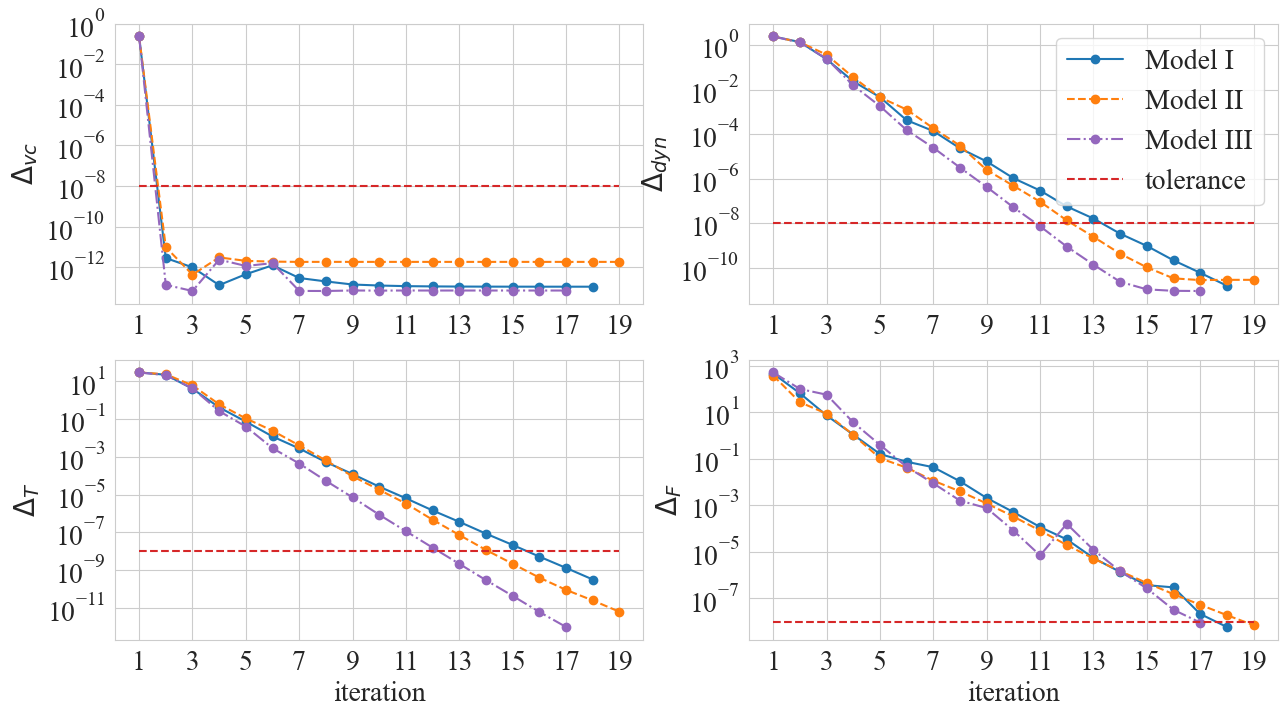

In [29]:
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.plot(index[0],vc[0],'o-',color='tab:blue',label='Model I')
plt.plot(index[1],vc[1],'o--',color='tab:orange',label='Model II')
plt.plot(index[2],vc[2],'o-.',color='tab:purple',label='Model III')
plt.plot(index[1],index[1]*0+tol_vc,'--',color='tab:red',label='tolerance')
plt.ylabel(r'$\Delta_{vc}$',**csfont)
plt.yscale('log')
plt.grid(True)
plt.xticks(fontsize=fS)
plt.yticks(fontsize=fS)
plt.xticks([i*2+1 for i in range(10)])

plt.subplot(222)
plt.plot(index[0],dyn_error[0],'o-',color='tab:blue',label='Model I')
plt.plot(index[1],dyn_error[1],'o--',color='tab:orange',label='Model II')
plt.plot(index[2],dyn_error[2],'o-.',color='tab:purple',label='Model III')
plt.plot(index[1],index[1]*0+tol_dyn,'--',color='tab:red',label='tolerance')
plt.ylabel(r'$\Delta_{dyn}$',**csfont)
plt.yscale('log')
plt.grid(True)
plt.xticks(fontsize=fS)
plt.yticks(fontsize=fS)
plt.legend(prop=font)
plt.xticks([i*2+1 for i in range(10)])

plt.subplot(223)
plt.plot(index[0],del_traj[0],'o-',color='tab:blue',label='Model I')
plt.plot(index[1],del_traj[1],'o--',color='tab:orange',label='Model II')
plt.plot(index[2],del_traj[2],'o-.',color='tab:purple',label='Model III')
plt.plot(index[1],index[1]*0+tol_traj,'--',color='tab:red',label='tolerance')
plt.xlabel('iteration',**csfont)
plt.ylabel(r'$\Delta_T$',**csfont)
plt.yscale('log')
plt.xticks([i*2+1 for i in range(10)])
plt.xticks(fontsize=fS)
plt.yticks(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)

plt.subplot(224)
plt.plot(index[0],del_funl[0],'o-',color='tab:blue',label='Model I')
plt.plot(index[1],del_funl[1],'o--',color='tab:orange',label='Model II')
plt.plot(index[2],del_funl[2],'o-.',color='tab:purple',label='Model III')
plt.plot(index[1],index[1]*0+tol_funl,'--',color='tab:red',label='tolerance')
plt.xlabel('iteration',**csfont)
plt.ylabel(r'$\Delta_F$',**csfont)
plt.yscale('log')
plt.xticks([i*2+1 for i in range(10)])
plt.xticks(fontsize=fS)
plt.yticks(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)

plt.savefig('../images/unicycle/convergence_result.pdf')

# Computational time

In [14]:
t_derivs,t_trajopt,t_funlopt,t_lipshitz = [],[],[],[]
for history in history_all :
    time_derivs = []
    time_trajopt = []
    time_funlopt = []
    time_lipschitz = []
    for his in history[1:] :
        time_derivs.append(his['t_derivs'])
        time_trajopt.append(his['t_trajopt'])
        time_funlopt.append(his['t_funlopt'])
        time_lipschitz.append(his['t_Lipschitz'])
    def mean_list(l) :
        return sum(l)/len(l)
    mean_derivs = mean_list(time_derivs)
    mean_trajopt = mean_list(time_trajopt)
    mean_funlopt = mean_list(time_funlopt)
    mean_lipschitz = mean_list(time_lipschitz)
    t_derivs.append(mean_derivs)
    t_trajopt.append(mean_trajopt)
    t_funlopt.append(mean_funlopt)
    t_lipshitz.append(mean_lipschitz)
print("mean_derivs",t_derivs)
print("mean_trajopt",t_trajopt)
print("mean_funlopt",t_funlopt)
print("mean_lipschitz",t_lipshitz)

mean_derivs [0.005614154479082893, 0.0057487355338202584, 0.005689173936843872]
mean_trajopt [0.02550341101253734, 0.025832176208496094, 0.025477662682533264]
mean_funlopt [0.5772387981414795, 0.6913664473427666, 0.8801445215940475]
mean_lipschitz [0.8634320567635929, 0.8952478170394897, 0.9035535901784897]


In [15]:
print("\\begin{table}")
print("\caption{Average computational time (s) for each iteration}")
print("\label{tb:computation_time}")
print("\centering{}%")
print("\\begin{tabular}{cccc}")
print("\\toprule ")
print("Subproblem &  Trajectory update & Estimate $\gamma_k$ & Funnel update\\tabularnewline")
print("\midrule")
print("Model \\textrm{I} & "+str(round(t_trajopt[0],3))+" & "+str(round(t_lipshitz[0],3))+" & "
      +str(round(t_funlopt[0],3))+" \\  ")
print("\midrule ")
print("Model \\textrm{II} & "+str(round(t_trajopt[1],3))+" & "+str(round(t_lipshitz[1],3))+" & "
      +str(round(t_funlopt[1],3))+" \\  ")
print("\midrule ")
print("Model \\textrm{II} & "+str(round(t_trajopt[2],3))+" & "+str(round(t_lipshitz[2],3))+" & "
      +str(round(t_funlopt[2],3))+" \\  ")
print("\\bottomrule")
print("\end{tabular}")
print("\end{table}")

\begin{table}
\caption{Average computational time (s) for each iteration}
\label{tb:computation_time}
\centering{}%
\begin{tabular}{cccc}
\toprule 
Subproblem &  Trajectory update & Estimate $\gamma_k$ & Funnel update\tabularnewline
\midrule
Model \textrm{I} & 0.026 & 0.863 & 0.577 \  
\midrule 
Model \textrm{II} & 0.026 & 0.895 & 0.691 \  
\midrule 
Model \textrm{II} & 0.025 & 0.904 & 0.88 \  
\bottomrule
\end{tabular}
\end{table}


# state funnel

In [32]:
def plot_traj_model(idx) :
    history = history_all[idx]
    history_linear = history_linear_all[idx]
    xbar = history[-1]['x']
    ubar = history[-1]['u']
    Qbar = history[-1]['Q']
    Ybar = history[-1]['Y']
    Kbar = history[-1]['K']

    xbar_linear = history_linear[-1]['x']
    ubar_linear = history_linear[-1]['u']
    Qbar_linear = history_linear[-1]['Q']
    Ybar_linear = history_linear[-1]['Y']
    Kbar_linear = history_linear[-1]['K']

    fS = 25
    plt.figure(0,figsize=(15,7))
    plot_comparison(xbar,xbar_linear,c_list,H_list,Qbar,Qbar_linear,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,fS=fS,flag_label=(idx==0))
    # plt.legend(prop=font)
    # if idx == 0 :
    #     plt.legend(prop=font)
    plt.grid(True)
    plt.axis([-1.0, 9.0, -1.0, 5.0])
    plt.xticks(fontsize=fS)
    plt.yticks(fontsize=fS)

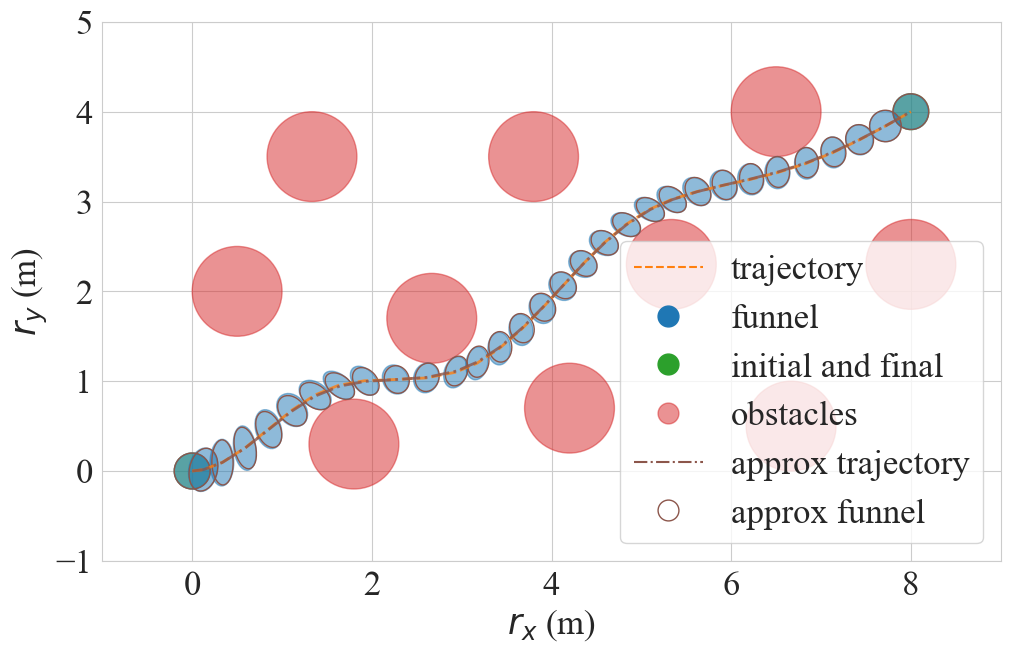

In [33]:
idx = 0
plot_traj_model(idx)
plt.savefig("../images/unicycle/model_" + str(idx) + "_traj_result.pdf")

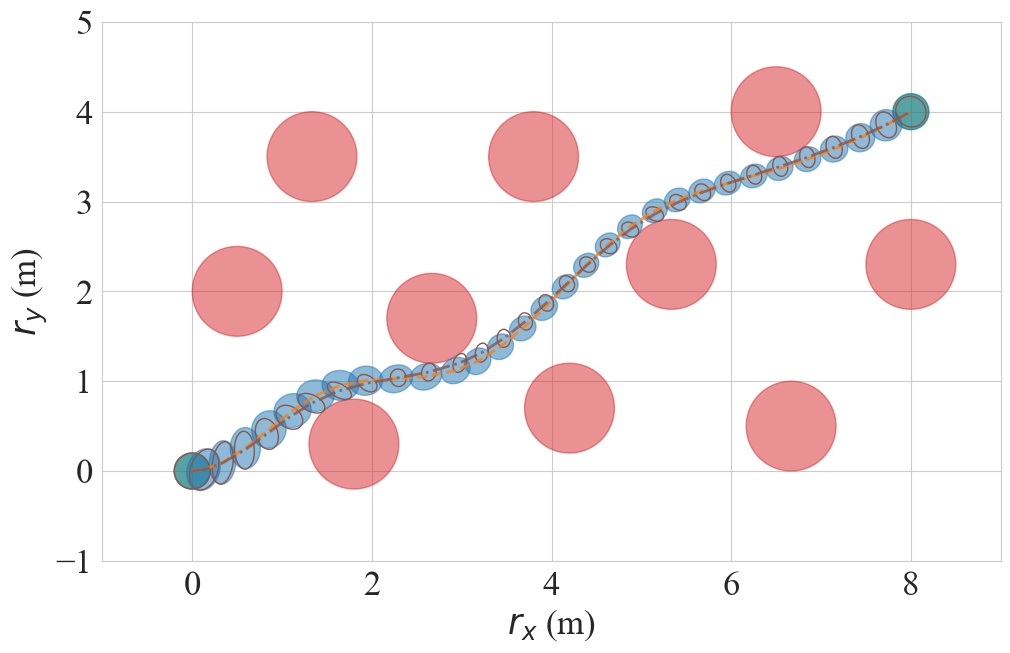

In [34]:
idx = 1
plot_traj_model(idx)
plt.savefig("../images/unicycle/model_" + str(idx) + "_traj_result.pdf")

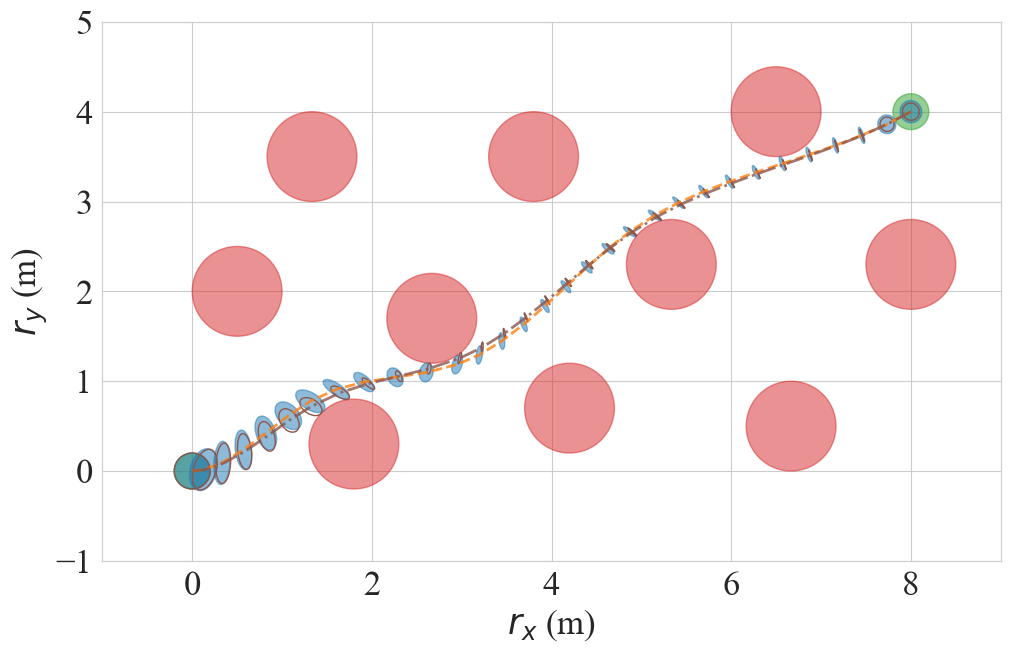

In [35]:
idx = 2
plot_traj_model(idx)
plt.savefig("../images/unicycle/model_" + str(idx) + "_traj_result.pdf")

# input funnel

In [49]:
# obtain input funnel
def get_input_margin_by_funnel(Q,K) :
    N = len(Q) - 1
    R1 = []
    for i in range(N+1) :
        R1.append(K[i]@Q[i]@K[i].T)
    a1 = np.array([1,0])
    a2 = np.array([0,1])
    vfunl1 = []
    wfunl1 = []
    for i in range(N+1) :
        vfunl1.append(np.sqrt(a1.T@R1[i]@a1))
        wfunl1.append(np.sqrt(a2.T@R1[i]@a2))
    vfunl1 = np.array(vfunl1)
    wfunl1 = np.array(wfunl1)
    return vfunl1,wfunl1
def plot_input_model(idx) :
    history = history_all[idx]
    history_linear = history_linear_all[idx]
    xbar = history[-1]['x']
    ubar = history[-1]['u']
    Qbar = history[-1]['Q']
    Ybar = history[-1]['Y']
    Kbar = history[-1]['K']

    vfun,wfun = get_input_margin_by_funnel(Qbar[:N],Kbar)

    fS = 25
    plt.figure(0,figsize=(7,10))
    alpha = 1.0
    t_index = np.array(range(N+1))*delT
    plt.subplot(211)
    plt.plot(t_index, t_index*0+myConst.vmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
    plt.plot(t_index, t_index*0+myConst.vmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
    plt.step(t_index, [*ubar[:N,0],ubar[N-1,0]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
    plt.step(t_index, [*(ubar[:N,0]+vfun[:N]),ubar[N-1,0]+vfun[N-1]],'-',color='tab:blue',alpha=1.0,where='post',linewidth=2.0)
    plt.step(t_index, [*(ubar[:N,0]-vfun[:N]),ubar[N-1,0]-vfun[N-1]],'-',color='tab:blue',alpha=1.0,where='post',linewidth=2.0)
    plt.plot(1e3, 1e3,'-',color='tab:blue',alpha=1.0,linewidth=2.0,label='funnel')
    # plt.xlabel('time (s)', fontsize = fS)
    plt.ylabel('$u_v$ (m/s)', fontsize = fS)
    plt.xticks(fontsize=fS)
    plt.yticks(fontsize=fS)
    plt.axis([0.0, tf, -0.2, 1.7])
    plt.grid(True)
    if idx == 0 :
        plt.legend(fontsize=fS)
    plt.subplot(212)
    plt.plot(t_index, t_index*0+myConst.wmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
    plt.plot(t_index, t_index*0+myConst.wmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
    plt.step(t_index, [*ubar[:N,1],ubar[N-1,1]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
    plt.step(t_index, [*(ubar[:N,1]+wfun[:N]),ubar[N-1,1]+wfun[N-1]],'-',color='tab:blue',alpha=1.0,where='post',linewidth=2.0)
    plt.step(t_index, [*(ubar[:N,1]-wfun[:N]),ubar[N-1,1]-wfun[N-1]],'-',color='tab:blue',alpha=1.0,where='post',linewidth=2.0)
    plt.plot(1e3, 1e3,'-',color='tab:blue',alpha=1.0,linewidth=2.0,label='funnel')
    plt.xlabel('time (s)', fontsize = fS)
    plt.ylabel('$u_{\Theta}$ (rad/s)', fontsize = fS)
    plt.xticks(fontsize=fS)
    plt.yticks(fontsize=fS)
    plt.axis([0.0, tf, -1.2, 1.2])
    # plt.legend(fontsize=fS)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.grid(True)


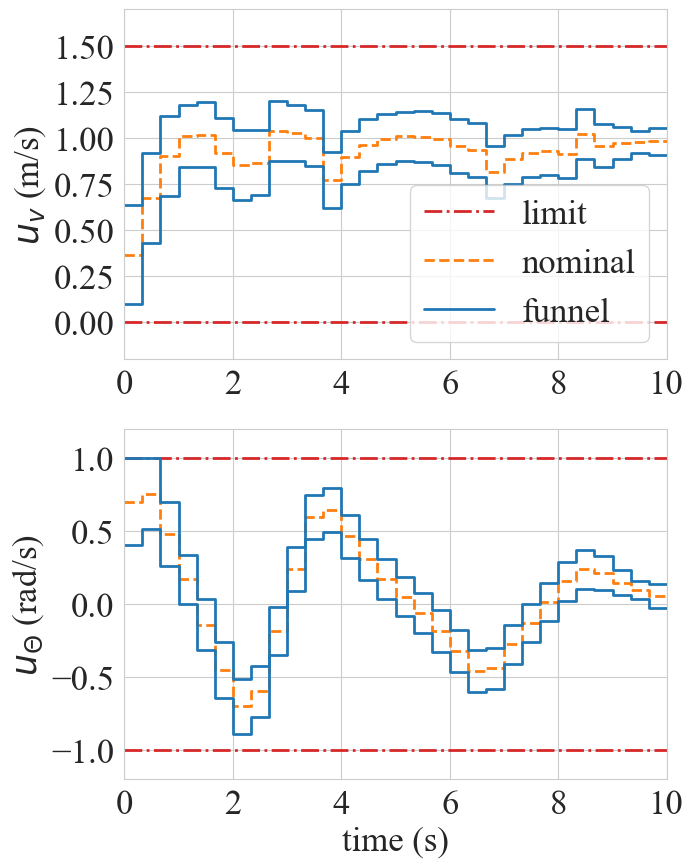

In [53]:
idx = 0
plot_input_model(idx)
plt.savefig("../images/unicycle/model_" + str(idx) + "_input_result.pdf",bbox_inches='tight')

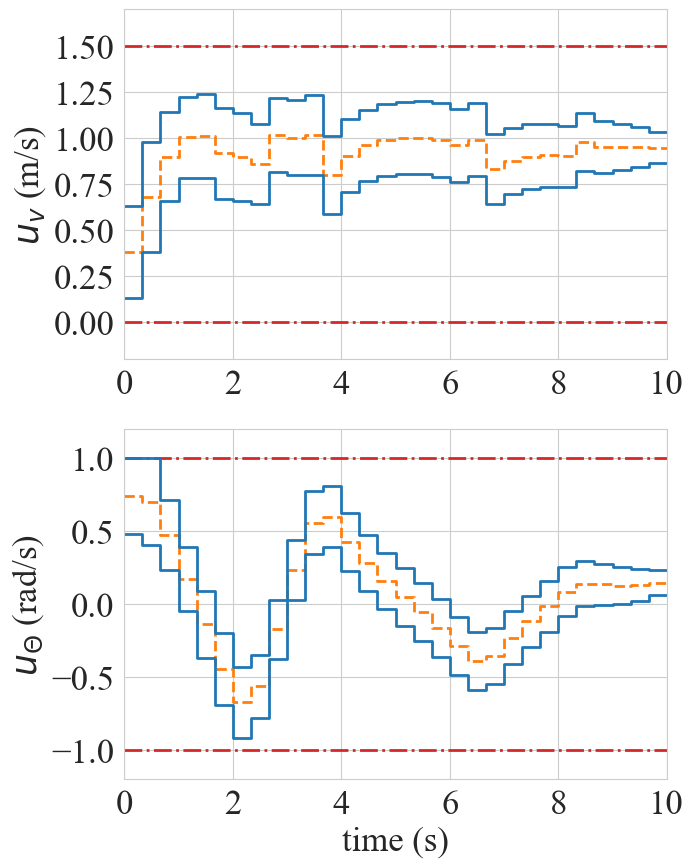

In [54]:
idx = 1
plot_input_model(idx)
plt.savefig("../images/unicycle/model_" + str(idx) + "_input_result.pdf",bbox_inches='tight')

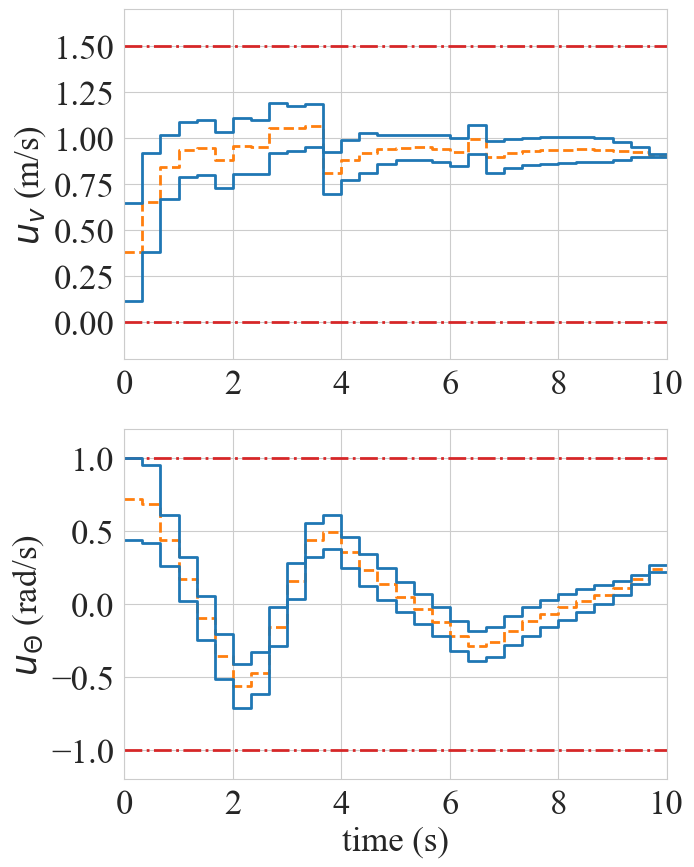

In [55]:
idx = 2
plot_input_model(idx)
plt.savefig("../images/unicycle/model_" + str(idx) + "_input_result.pdf",bbox_inches='tight')

# Evaluate the generated traj and funl for Model II

In [42]:
from utils.utils_alg import forward_full_with_K,get_sample_trajectory
import scipy

In [44]:
def get_radii_list(xsamp,xbar,Qbar) :
    radii_list = []
    for x in xsamp :
        radii = np.zeros(N+1)
        for i in range(N+1) :
            radii[i] = (x[i]-xbar[i]).T@np.linalg.inv(Qbar[i])@(x[i]-xbar[i])
            if radii[i] > 1 + 1e-8 :
                print("invariance violation",radii[i])
        radii_list.append(radii)
    return radii_list
def plot_invariance_model(idx) :
    history = history_all[idx]
    xbar = history[-1]['x']
    ubar = history[-1]['u']
    Qbar = history[-1]['Q']
    Ybar = history[-1]['Y']
    Kbar = history[-1]['K']
    gammabar = history[-1]['gamma']

    history_linear = history_linear_all[idx]
    xbar_linear = history_linear[-1]['x']
    ubar_linear = history_linear[-1]['u']
    Qbar_linear = history_linear[-1]['Q']
    Ybar_linear = history_linear[-1]['Y']
    Kbar_linear = history_linear[-1]['K']

    if idx == 0 :
        myModel = UnicycleModel.unicycle1('unicycle','numeric_central')
    elif idx == 1 :
        myModel = UnicycleModel.unicycle2('unicycle','numeric_central')
    if idx == 2 :
        myModel = UnicycleModel.unicycle3('unicycle','numeric_central')

    x0_sample = []
    num_sample = 100
    for i in range(num_sample) :
        z = np.random.randn(ix)
        z = z / np.linalg.norm(z)
        # z = np.array([0,1,0])
        x_s = xbar[0] + scipy.linalg.sqrtm(Qbar[0])@z
        x0_sample.append(x_s)

    tsam,xsam,usam,wsam,xsamp = get_sample_trajectory(xi,x0_sample,xbar,ubar,Qbar,Ybar,myModel,N,ix,iu,iw,delT,
                                            flag_noise=True)
    x0_sample = []
    for i in range(num_sample) :
        z = np.random.randn(ix)
        z = z / np.linalg.norm(z)
        x_s = xbar_linear[0] + scipy.linalg.sqrtm(Qbar_linear[0])@z
        x0_sample.append(x_s)
    tsam_linear,xsam_linear,usam_linear,wsam_linear,xsamp_linear = get_sample_trajectory(xi,x0_sample,
                                                                        xbar_linear,ubar_linear,
                                                                        Qbar_linear,Ybar_linear,myModel,N,ix,iu,iw,delT,
                                                                        flag_noise=True)

    radii_list = get_radii_list(xsamp,xbar,Qbar)
    radii_list_linear = get_radii_list(xsamp_linear,xbar_linear,Qbar_linear)

    fS = 20
    idx_plot = [i for i in range(N+1)]
    fig, ax = plt.subplots(figsize=[5, 3])
    for radii in radii_list_linear :
        ax.plot(idx_plot,radii,color='tab:brown',alpha=0.9)
    for radii in radii_list :
        ax.plot(idx_plot,radii,'--',color='tab:purple',alpha=0.8)
    ax.plot(idx_plot,radii*0+1,'-.',color='tab:red',alpha=1.0,label='limit')
    plt.xlabel('$k$', fontsize = fS)
    plt.ylabel('$r^Q_k$', fontsize = fS)
    plt.grid(True)
    plt.xticks(fontsize=fS)
    plt.yticks(fontsize=fS)
    if idx != 2 :
        plt.axis([0,30,-0.2,1.2])
    else :
        plt.axis([0,30,-0.2,2.0])
    plt.plot(1e3,1e3,'--',color='tab:purple',alpha=1.0,label='proposed')
    plt.plot(1e3,1e3,color='tab:brown',alpha=1.0,label='approx')
    if idx == 0 :
        plt.legend(fontsize=fS)
    # if idx != 2 :
    if idx == 1 :
        # axins = ax.inset_axes([5, 15, 0.0, 0.6])
        axins = ax.inset_axes([0.2, 0.05, 0.3, 0.5])

        for radii in radii_list_linear :
            axins.plot(idx_plot,radii,color='tab:brown',alpha=0.9)
        for radii in radii_list :
            axins.plot(idx_plot,radii,'--',color='tab:purple',alpha=0.8)
        axins.plot(idx_plot,radii*0+1,'-.',color='tab:red',alpha=1.0,label='limit')

        axins.set_xlim(0.5, 4.5)
        axins.set_ylim(0.9, 1.1)
        axins.set_xticklabels([])
        axins.set_yticklabels([])
        ax.indicate_inset_zoom(axins, edgecolor="black",linewidth=2.0)
    plt.grid(True)
    plt.rcParams["font.family"] = "Times New Roman"

there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
invariance violation 1.027051259494347
invariance violation 1.071880978237359
invariance violation 1.0796174805516632
invariance violation 1.0549268505330904
invariance violation 1.0167656069123832
invariance violation 1.0152409648622227


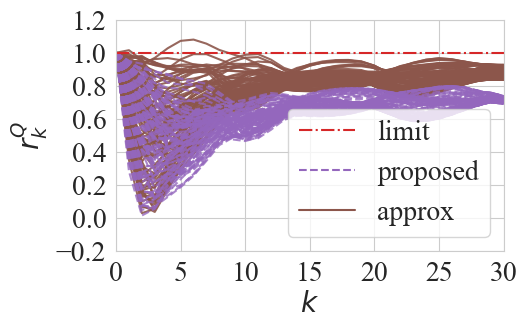

In [46]:
idx = 0
plot_invariance_model(idx)
plt.savefig("../images/unicycle/model_" + str(idx) + "_invariance_result.pdf",bbox_inches='tight')

there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
invariance violation 1.0086314733753379
invariance violation 1.0004948835878016
invariance violation 1.0211281389891662
invariance violation 1.0165679525786824
invariance violation 1.0042447552834932
invariance violation 1.010573273287238
invariance violation 1.0100595808948745


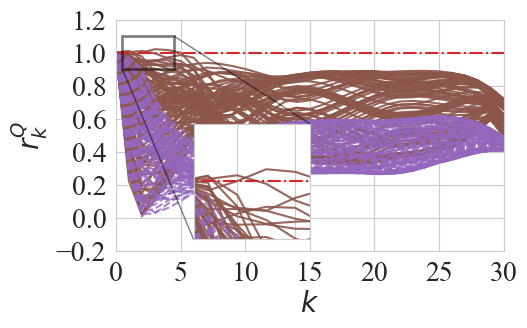

In [47]:
idx = 1
plot_invariance_model(idx)
plt.savefig("../images/unicycle/model_" + str(idx) + "_invariance_result.pdf",bbox_inches='tight')

there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is i

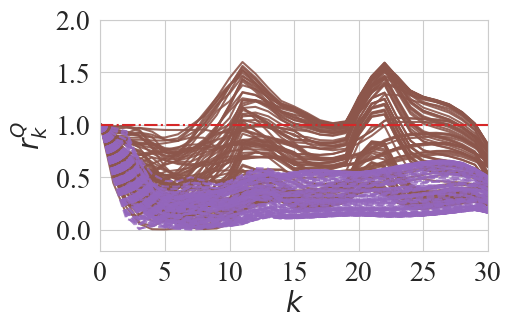

In [48]:
idx = 2
plot_invariance_model(idx)
plt.savefig("../images/unicycle/model_" + str(idx) + "_invariance_result.pdf",bbox_inches='tight')